# 0. IMPORTS

## 0.1. Libraries

In [1]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import requests

from IPython.display       import Image
from matplotlib            import gridspec
from tabulate              import tabulate
from scipy.stats           import chi2_contingency
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

pd.options.mode.chained_assignment = None  # default='warn'

## 0.2. Helper Functions

In [2]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency (cm )[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1 )))

def mean_absolute_percentage_error (y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index = [0])

def cross_validation (x_training, kfold, model_name, model, verbose=False):
    # error lists creation
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKfold Number: {}'.format( k ) )
            
        # filtering dataset
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        training = x_training[x_training['date'] < validation_start_date]

        # training dataset
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        # validation dataset
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        ## model
        m = model.fit(xtraining, ytraining)

        ## prediction
        yhat = m.predict(xvalidation)

        ## performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # error lists value addition
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': np.round(np.mean(mae_list)).astype(str) + '+/-' + np.round(np.std(mae_list)).astype(str),
                         'MAPE': np.round(np.mean(mape_list)).astype(str) + '+/-' + np.round(np.std(mape_list)).astype(str),
                         'RSME': np.round(np.mean(rmse_list)).astype(str) + '+/-' + np.round(np.std(rmse_list)).astype(str)}, index=[0])

## 0.3. Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on = 'Store')

## 0.4. Graph Visualization

In [41]:
from IPython.core.display import HTML

def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [18, 8]
   plt.rcParams['font.size'] = 20
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )
   sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. DESCRIBE DATA

In [42]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [43]:
# list(df1.columns)

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# CamelCase to SnakeCase
snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [44]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [45]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
13685,306,7,2015-07-19,0,0,0,0,0,0,a,a,5100.0,4.0,2007.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


In [46]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [47]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [48]:
# competition_distance (2642 NAs)

# df1['competition_distance'].max() = 75860.0

df1['competition_distance'] = df1['competition_distance'].fillna(200000)


# competition_open_since_month (323348 NAs)
df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month)
# similarly: df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )


# competition_open_since_year (323348 NAs)
df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year)


# promo2_since_week (508031 NAs)
df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['date'].dt.week)


# promo2_since_year (508031 NAs)
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(df1['date'].dt.year)


# promo_interval (508031 NAs)
month_map = {1: 'Jan',
             2: 'Feb',
             3: 'Mar',
             4: 'Apr',
             5: 'May',
             6: 'Jun',
             7: 'Jul',
             8: 'Aug',
             9: 'Sep',
             10: 'Oct',
             11: 'Nov',
             12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

# New variable: check if sales date was in the period of promotion
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

<ipython-input-48-669cc2e20aaf>:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['date'].dt.week)


## 1.6. Change Data Type

In [49]:
# competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

In [50]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Variables

In [51]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.mean())
ct2 = pd.DataFrame(num_attributes.median())

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.std())
d2 = pd.DataFrame(num_attributes.min())
d3 = pd.DataFrame(num_attributes.max())
d4 = pd.DataFrame(num_attributes.max() - num_attributes.min())
d5 = pd.DataFrame(num_attributes.skew())
d6 = pd.DataFrame(num_attributes.kurtosis())

# concat
df_num = pd.concat([ct1, ct2, d1, d2, d3, d4, d5, d6], axis = 1)
df_num.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
df_num

,mean,median,std,min,max,range,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,1114.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,6.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,199980.0,10.242344,147.789712
competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,11.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,115.0,-7.235657,124.071304


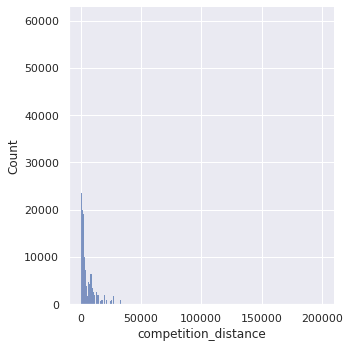

In [52]:
sns.displot(df1['competition_distance'], kde = False);

### 1.7.2. Categorical Variables

In [53]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

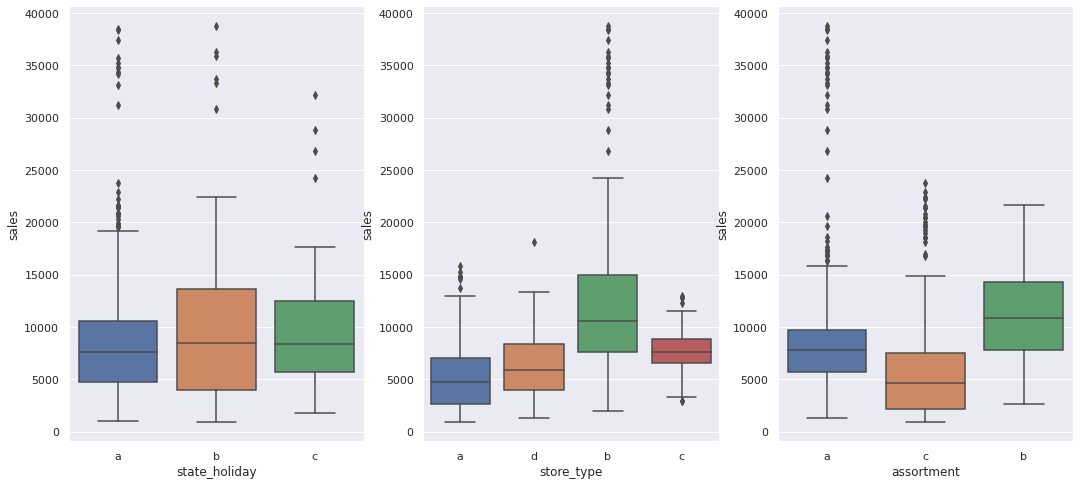

In [54]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)] # filtering data for better visualization

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1);

# 2. FEATURE ENGINEERING

In [55]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

In [ ]:
Image(filename='Daily_Store_Sales.png')

## 2.2. Hypothesis Development

Creation of hypothesis for each category in the Mind Map, while related to the response variable << **sales** >> .

PS.: Clients & Location: none information on dataset

### 2.2.1. Store Hypothesis

**1.** Stores with **more diversified products** should sell **more**

**2.** Stores with **closer competitors** should sell **less**

### 2.2.2. Product Hypothesis

**1.** Stores with **longer active promotions** should sell **more**

**2.** Stores with **more consecutive promotions** should sell **more**

### 2.2.3. Time Series Hypothesis

**1.** Stores, during **school holidays**, should sell **more**

**2.** Stores, in **Christmas period**, should sell **more** than during other holidays

**3.** Stores, during **weekends**, should sell **less**

**4.** At the **first half of the month**, stores should sell **more**

**5** In the **first semester of the year**, stores should sell **less**

**6.** **Throughout the years**, stores should sell **more**.

## 2.3. Feature Engineering

### 2.3.1. Created Columns

In [68]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [57]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week_of_year
df2['week_of_year'] = df2['date'].dt.week

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

###

# competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

<ipython-input-57-86fe9e2cae40>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.week


### 2.3.2. Modified Columns

In [58]:
# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# 3. FILTERING VARIABLES

In [69]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [70]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

In [71]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4. EXPLORATORY DATA ANALYSIS (EDA)

In [72]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

In [ ]:
sns.distplot(df4['sales']);

### 4.1.2. Numerical Variables

In [ ]:
num_attributes.hist(bins = 25);

### 4.1.3. Categorical Variables

In [ ]:
# state_holiday
aux1 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(3, 2, 1)
sns.countplot(aux1['state_holiday']);

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade = True, label = 'public_holiday');
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade = True, label = 'easter_holiday');
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], shade = True, label = 'christmas');
plt.legend();


# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type']);

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade = True, label = 'a');
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade = True, label = 'b');
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade = True, label = 'c');
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade = True, label = 'd');
plt.legend();


# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment']);

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade = True, label = 'basic');
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade = True, label = 'extra');
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade = True, label = 'extended');
plt.legend();

## 4.2. Bivariate Analysis - Hypothesis Validation

### 4.2.1. Individual Analysis of the Hypothesis

**H1.** Stores with **more diversified products** should sell **more**

**TRUE**, when compared to basic assortment, although extended assortment does not sell more than extra

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

**H2.** Stores with **closer competitors** should sell **less**

**FALSE** - sales do not vary much

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

plt.subplot(1, 3, 1)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H3.** Stores with **longer active promotions** should sell **more**

**TRUE** - There is a tendency of more average sales for stores with longer periods of promotion

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

grid = gridspec.GridSpec(2,3)


# extended promotion
aux2 = aux1.loc[(aux1['promo_time_week'] >= 0), :]

plt.subplot(grid[0,0])
bins = list(np.arange(0,313,20))
aux2['promo_time_week_binned'] = pd.cut(aux2['promo_time_week'], bins = bins)
aux3 = aux2[['promo_time_week_binned', 'sales']].groupby('promo_time_week_binned').mean().reset_index()
sns.barplot(x = 'promo_time_week_binned', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);


# regular promotion
aux4 = aux1[aux1['promo_time_week'] < 0]

plt.subplot(grid[1,0])
bins = list(np.arange(-126,0,5))
aux4['promo_time_week_binned'] = pd.cut(aux4['promo_time_week'], bins = bins)
aux5 = aux4[['promo_time_week_binned', 'sales']].groupby('promo_time_week_binned').mean().reset_index()
sns.barplot(x = 'promo_time_week_binned', y = 'sales', data = aux5);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux4);


plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H4.** Stores with **more consecutive promotions** should sell **more**

**FALSE** - Stores with regular promotions only sell more

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index()

In [ ]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Regular + Extended', 'Regular']);

**H5.** Stores, during **school holidays**, should sell **more**

**TRUE**, except for the months of January, April, November and December

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

# analysis per month
plt.subplot(2, 1, 2)
aux2 = df4[['school_holiday', 'month', 'sales']].groupby(['school_holiday', 'month']).mean().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

**H6.** Stores, in **Christmas period**, should sell **more** than during other holidays

**FALSE** - Stores sell less in Christmas than in public holiday or easter

In [ ]:
# 2015 removed - data is only until 31/07/2015

aux1 = df4[(df4['state_holiday'] != 'regular_day') & (df4['year'] < 2015)]

aux2 = aux1[['state_holiday', 'year', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()

sns.barplot(x = 'state_holiday', y = 'sales', hue = 'year', data = aux2);

**H7.** Stores, during **weekends**, should sell **less**

**TRUE**

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H8.** At the **first half of the month**, stores should sell **more**

**TRUE**

In [ ]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H9.** In the **first semester of the year**, stores should sell **less**

**TRUE** - Analysis for the years of 2013 and 2014 (the data from 2015 stops in july)

In [ ]:
# 2015 removed - data only until 31/07/2015

aux = df4[df4['year'] < 2015]

aux1 = aux[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H10.** **Throughout the years**, stores should sell **more**

**FALSE** - Even though data of 2015 is incomplete, it was considered to observe the tendency of sales reduction throughout years

In [ ]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### 4.2.2. General Hypothesis Review

In [ ]:

tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1 - Stores with more diversified products should sell more', 'True', 'Medium'],
       ['H2 - Stores with closer competitors should sell less', 'False', 'Low'],
       ['H3 - Stores with longer active promotions should sell more', 'True', 'Medium'],
       ['H4 - Stores with more consecutive promotions should sell more', 'False', 'Low'],
       ['H5 - Stores, during school holidays, should sell more', 'True', 'Low'],
       ['H6 - Stores, in Christmas period, should sell more than during other holidays', 'False', 'Medium'],
       ['H7 - Stores, during weekends, should sell less', 'True', 'High'],
       ['H8 - At the first half of the month, stores should sell more', 'True', 'High'],
       ['H9 - In the first semester of the year, stores should sell less', 'True', 'High'],
       ['H10 - Throughout the years, stores should sell more', 'False', 'High']
      ]
print(tabulate(tab, headers='firstrow'))

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

In [ ]:
sns.heatmap(num_attributes.corr(method = 'pearson'), annot = True);

### 4.3.2. Categorical Attributes

In [ ]:
a = df4.select_dtypes(include='object')

# calculating cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset
d = pd.DataFrame({'state_holiday':[a1,a2,a3], 
                  'store_type':[a4,a5,a6],
                  'assortment':[a7,a8,a9] })

d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 5. DATA PREPARATION

In [73]:
df5 = df4.copy()

## 5.1. Normalization

Technique that works well for variables that have a normal distribution. As this does not occur in the numerical variables presented, this technique **will not be applied in this case**.

## 5.2. Rescaling

In [75]:
mms = MinMaxScaler()
rs = RobustScaler()

# competition_distance (Robust Scaler)
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

In [74]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.3. Transformation

### 5.3.1. Response Variable

In [76]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2. Encoding

In [77]:
#state_holiday - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoder
assort_dict = {'basic': 1,
               'extra': 2,
               'extended': 3}
df5['assortment'] = df5['assortment'].map(assort_dict)

### 5.3.3. Nature Transformation

In [78]:
# day_of_week
df5['day_of_week_sin'] = np.sin(2 * np.pi * df5['day_of_week'] / 7) 
df5['day_of_week_cos'] = np.cos(2 * np.pi * df5['day_of_week'] / 7) 

# day
df5['day_sin'] = np.sin(2 * np.pi * df5['day'] / 30) 
df5['day_cos'] = np.cos(2 * np.pi * df5['day'] / 30) 

# month
df5['month_sin'] = np.sin(2 * np.pi * df5['month'] / 12) 
df5['month_cos'] = np.cos(2 * np.pi * df5['month'] / 12) 

# week_of_year
df5['week_of_year_sin'] = np.sin(2 * np.pi * df5['week_of_year'] / 52) 
df5['week_of_year_cos'] = np.cos(2 * np.pi * df5['week_of_year'] / 52) 

# 6. FEATURE SELECTION

In [79]:
df6 = df5.copy()

In [80]:
# removing colinear variables

cols_drop = ['day_of_week', 'day', 'month', 'week_of_year', 'year_week', 'competition_since', 'promo_since']

df6 = df6.drop(cols_drop, axis = 1)

df6.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'day_of_week_sin', 'day_of_week_cos',
       'day_sin', 'day_cos', 'month_sin', 'month_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

## 6.1. Split dataframe into training and test dataset

In [81]:
df6['date'].max() - pd.Timedelta(value = 6, unit = 'W')

Timestamp('2015-06-19 00:00:00')

In [82]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))


# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [ ]:
# # conversion of df/series to numpy and remotion of variables that do not compose training ('sales' and 'date')
# x_train_n = X_train.drop(['sales', 'date'], axis=1).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs = -1)

# # define Boruta
# boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

### 6.2.1. Best Features

In [ ]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['sales', 'date'], axis = 1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# # colunas desconsideradas pelo boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3. Saving Boruta Best Features

In [83]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

#columns to add
feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7. MACHINE LEARNING MODELS

In [84]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Cross-Validation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [ ]:
# # test dataset
# aux1 = x_test.copy()
# aux1['sales'] = y_test.copy()

# # prediction
# aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
# aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
# yhat_baseline = aux1['predictions']

# # performance
# baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
# baseline_result

## 7.2. Linear Regression Model

In [ ]:
# # model
# lr = LinearRegression().fit(x_train, y_train)

# # predicition
# yhat_lr = lr.predict(x_test)

# # performance
# lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
# lr_result

### 7.1.2.  Linear Regression Model - Cross Validation

In [ ]:
# lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=True)
# lr_result_cv

## 7.3. Linear Regression Regularized Model (Lasso)

In [ ]:
# # model
# lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# # predicition
# yhat_lrr = lrr.predict(x_test)

# # performance
# lrr_result = ml_error('Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
# lrr_result

### 7.1.3.  Lasso - Cross Validation

In [ ]:
# lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
# lrr_result_cv

## 7.4. Random Forest Model

In [ ]:
# # model
# rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

# # predicition
# yhat_rf = rf.predict(x_test)

# # performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

### 7.1.4. Random Forest Regressor - Cross Validation

In [ ]:
# rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=False)
# rf_result_cv

## 7.5. XGBoost Model

In [ ]:
# # model
# model_xgb = xgb().fit(x_train, y_train)

# # predicition
# yhat_xgb = model_xgb.predict(x_test)

# # performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_rf))
# xgb_result

### 7.1.5. XGBoost Regressor - Cross Validation

In [ ]:
# xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
# xgb_result_cv

## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [ ]:
# modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
# modelling_result.sort_values('RMSE')

### 7.6.2. Real Performance (Cross Validation)

In [ ]:
# modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
# modelling_result_cv.sort_values('RMSE')

# 8. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [ ]:
param = ('n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15])

MAX_EVAL = 10

In [ ]:
final_result = pd.DataFrame()

for i in range (MAX_EVAL):
    # choose values for parameters randomly
    hp = (k: random.sample(v, 1)[0] for k, v in param.items())
    print(hp)
    
    # model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators = hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample = hp['subsample'],
                                 colsample_bytee = hp['colsample_bytree'],
                                 min_child_weight = hp['min_child_weight'])
    
    # prediction
    yhat_xgb = model_xgb.predict(x_test)
    
    # performance    
    result = cross_validation (x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])

## 8.2. Final Model

In [85]:
param_tuned = {'n_estimators': 3500,
               'eta': 0.01,
               'max_depth': 5,
               'subsample': 0.5,
               'colsample_bytree': 0.7,
               'min_child_weight': 15}

In [87]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                   n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree = param_tuned['colsample_bytree'],
                                   min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance    
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

[14:53:39] WARNING: ../src/learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1000.492542,0.151188,1446.391542


# 9. ERROR INTERPRETATION

In [ ]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [ ]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAPE'} )

# merge
df9_aux3 = pd.merge ( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']


# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
# Stores with more difficult prediction evaluation
df92.sort_values('MAPE', ascending=False).head()

In [ ]:
# Scatterplot visualization
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2. Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename( columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map( '${:,.2f}'.format )
df93

## 9.3. Machine Learning Performance

In [ ]:
df7['error'] = df7['sales'] - df7['predictions']

df7['error_rate'] = df7['predictions'] / df7['sales']

In [ ]:
sns.lineplot(x='date', y='sales', data=df7, label='Sales');
sns.lineplot(x='date', y='predictions', data=df7, label='Predictions');

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df7);
plt.axhline(1, linestyle = '--');

plt.subplot(2,2,3)
sns.distplot(df7['error']);

plt.subplot(2,2,4)
sns.scatterplot(df7['predictions'], df7['error']);

# 10. MODEL DEPLOYMENT

In [88]:
# Saving trained model
pickle.dump(model_xgb_tuned, open('/home/diandramelo/repos/Rossmann_Store_Sales/model_rossmann.pkl', 'wb'))

In [91]:
# Saving scalers: RobustScaler, MinMaxScaler, LabelEncoder
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))
pickle.dump(rs, open('/home/diandramelo/repos/Rossmann_Store_Sales/parameter/competition_time_month_scaler.pkl', 'wb')) 
pickle.dump(mms, open('/home/diandramelo/repos/Rossmann_Store_Sales/parameter/promo_time_week_scaler.pkl', 'wb')) 
pickle.dump(mms, open('/home/diandramelo/repos/Rossmann_Store_Sales/parameter/year_scaler.pkl', 'wb'))
pickle.dump(le, open('/home/diandramelo/repos/Rossmann_Store_Sales/parameter/store_type_scaler.pkl', 'wb'))

## 10.1. Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    
    def __init__(self):
        self.home_path                     = '/home/diandramelo/repos/Rossmann_Store_Sales/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb')) 
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb')) 
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):

        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
                    'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list( map( snakecase, cols_old ) )
        df1.columns = cols_new
        
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NA
        df1['competition_distance'] = df1['competition_distance'].fillna(200000)
        df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year)
        df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['date'].dt.week)
        df1['promo2_since_year'] = df1['promo2_since_year'].fillna(df1['date'].dt.year)
        month_map = {1: 'Jan',
                     2: 'Feb',
                     3: 'Mar',
                     4: 'Apr',
                     5: 'May',
                     6: 'Jun',
                     7: 'Jul',
                     8: 'Aug',
                     9: 'Sep',
                     10: 'Oct',
                     11: 'Nov',
                     12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True )
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Type
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1

    
    def feature_engineering(self, df2):
        
        ### 2.3.1. Created Columns
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week_of_year
        df2['week_of_year'] = df2['date'].dt.week

        # year_week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition_since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo_since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        ### 2.3.2. Modified Columns

        # state_holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        
        # 3. FILTERING VARIABLES

        ## 3.1. Filtering Rows
        df2 = df2[df2['open'] != 0]

        ## 3.2. Columns Selection
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    
    def data_preparation(self, df5):

        ## 5.2. Rescaling

        # competition_distance (Robust Scaler)
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3. Transformation

        ### 5.3.2. Encoding

        #state_holiday - One Hot Encoder
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        #store_type - Label Encoder
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoder
        assort_dict = {'basic': 1,
                       'extra': 2,
                       'extended': 3}
        df5['assortment'] = df5['assortment'].map(assort_dict)

        ### 5.3.3. Nature Transformation

        # day_of_week
        df5['day_of_week_sin'] = np.sin(2 * np.pi * df5['day_of_week'] / 7) 
        df5['day_of_week_cos'] = np.cos(2 * np.pi * df5['day_of_week'] / 7) 

        # day
        df5['day_sin'] = np.sin(2 * np.pi * df5['day'] / 30) 
        df5['day_cos'] = np.cos(2 * np.pi * df5['day'] / 30) 

        # month
        df5['month_sin'] = np.sin(2 * np.pi * df5['month'] / 12) 
        df5['month_cos'] = np.cos(2 * np.pi * df5['month'] / 12) 

        # week_of_year
        df5['week_of_year_sin'] = np.sin(2 * np.pi * df5['week_of_year'] / 52) 
        df5['week_of_year_cos'] = np.cos(2 * np.pi * df5['week_of_year'] / 52) 
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                          'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year',
                          'competition_time_month', 'promo_time_week', 'month_cos', 'month_sin', 'day_sin', 'day_cos',
                          'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

## 10.2. API Handler

In [4]:
import pickle
import pandas as pd
import os

from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Loading model
model = pickle.load(open('/home/diandramelo/repos/Rossmann_Store_Sales/model_rossmann.pkl', 'rb'))

# Initializing API
app = Flask(__name__)

@app.route('rossmann/predict', methods = ['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index = [0])
        else: # multiple examples
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
            
    else: # there is no data
        return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run(host='0.0.0.0', port=port)  

ModuleNotFoundError: No module named 'flask'

## 10.3. API Tester

In [4]:
# Loading test dataset
df10 = pd.read_csv('/home/diandramelo/repos/Rossmann_Store_Sales/data/test.csv')

In [18]:
# Merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# Choose store for prediction
df_test = df_test[df_test['Store'].isin([11, 15, 43])]

# Remove unrelevant info
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)

In [19]:
# Convert DataFrame to json
data = json.dumps(df_test.to_dict(orient='records'))

In [20]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
header = {'Content-type' : 'application/json'}
data = data 

r = requests.post(url, data = data, headers = header)
print('Status code: {}'.format(r.status_code))

Status code: 200


In [21]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())

In [22]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store number 11 will sell R$223,235.87 in the next 6 weeks
Store number 15 will sell R$269,314.03 in the next 6 weeks
Store number 43 will sell R$280,834.18 in the next 6 weeks
